# 付録A11: イノベーションの普及

## 学習目標

この付録では、ネットワーク上でのイノベーション（新しいアイデア、技術、行動）の普及について学びます。

- Rogersのイノベーション普及理論を理解する
- 採用者カテゴリとS字曲線を分析する
- ネットワーク構造が普及速度に与える影響をシミュレーションする
- Bassモデルとしきい値モデルを実装する

## セットアップ

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
import japanize_matplotlib

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = (10, 6)

# 再現性のための乱数シード
np.random.seed(42)
random.seed(42)

## A11.1 イノベーション普及理論

### Rogersの普及理論

Everett Rogers (1962) は、イノベーションが社会に広がるプロセスを体系化しました。

### 採用者カテゴリ

Rogersは採用者を5つのカテゴリに分類しました：

| カテゴリ | 割合 | 特徴 |
|----------|------|------|
| イノベーター | 2.5% | 冒険的、リスクを取る、最初に採用 |
| アーリーアダプター | 13.5% | オピニオンリーダー、尊敬される |
| アーリーマジョリティ | 34% | 慎重だが平均より早く採用 |
| レイトマジョリティ | 34% | 懐疑的、社会的圧力で採用 |
| ラガード | 16% | 伝統主義者、最後に採用 |

### S字曲線（ロジスティック曲線）

累積採用率は典型的にS字曲線を描きます：

$$N(t) = \frac{K}{1 + e^{-r(t-t_0)}}$$

- $K$: 最大採用数（市場規模）
- $r$: 普及速度
- $t_0$: 普及の中点

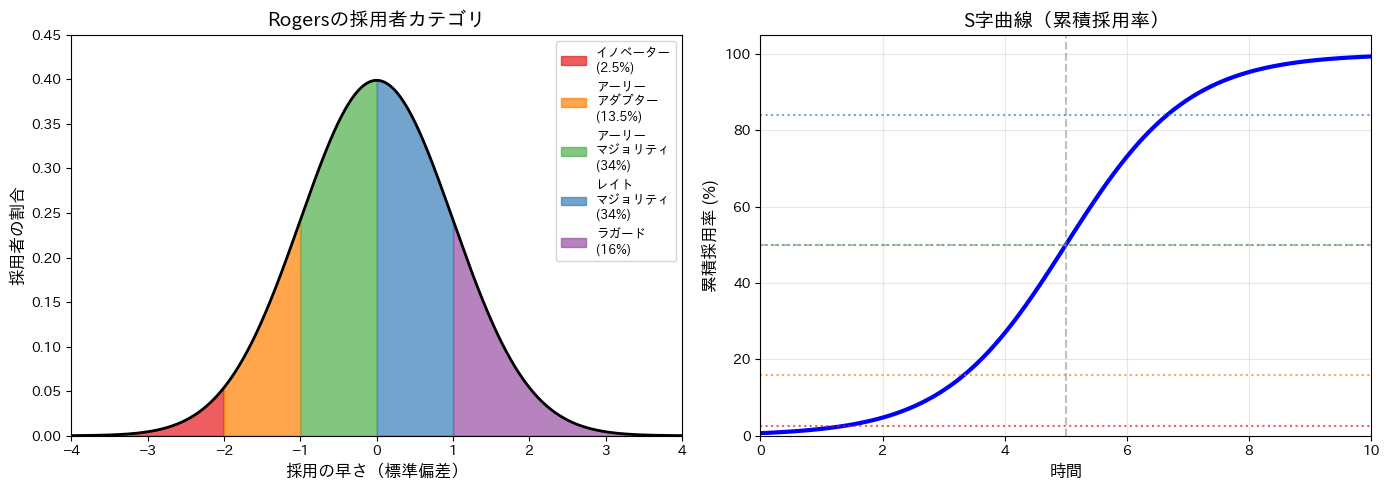

In [2]:
# 採用者カテゴリの可視化
def plot_adopter_categories():
    """Rogersの採用者カテゴリを正規分布で可視化"""
    x = np.linspace(-4, 4, 1000)
    y = (1 / np.sqrt(2 * np.pi)) * np.exp(-x**2 / 2)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 採用者カテゴリ
    categories = [
        ('イノベーター\n(2.5%)', -4, -2, '#e41a1c'),
        ('アーリー\nアダプター\n(13.5%)', -2, -1, '#ff7f00'),
        ('アーリー\nマジョリティ\n(34%)', -1, 0, '#4daf4a'),
        ('レイト\nマジョリティ\n(34%)', 0, 1, '#377eb8'),
        ('ラガード\n(16%)', 1, 4, '#984ea3')
    ]
    
    for name, x1, x2, color in categories:
        mask = (x >= x1) & (x <= x2)
        axes[0].fill_between(x[mask], y[mask], alpha=0.7, color=color, label=name)
    
    axes[0].plot(x, y, 'k-', linewidth=2)
    axes[0].set_xlabel('採用の早さ（標準偏差）', fontsize=12)
    axes[0].set_ylabel('採用者の割合', fontsize=12)
    axes[0].set_title('Rogersの採用者カテゴリ', fontsize=14)
    axes[0].legend(loc='upper right', fontsize=9)
    axes[0].set_xlim(-4, 4)
    axes[0].set_ylim(0, 0.45)
    
    # S字曲線（累積採用率）
    t = np.linspace(0, 10, 100)
    K = 100  # 最大採用率
    r = 1    # 普及速度
    t0 = 5   # 中点
    
    cumulative = K / (1 + np.exp(-r * (t - t0)))
    
    axes[1].plot(t, cumulative, 'b-', linewidth=3)
    axes[1].axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    axes[1].axvline(x=5, color='gray', linestyle='--', alpha=0.5)
    
    # 各カテゴリの境界
    boundaries = [2.5, 16, 50, 84, 100]
    boundary_colors = ['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8', '#984ea3']
    for i, (b, c) in enumerate(zip(boundaries[:-1], boundary_colors)):
        axes[1].axhline(y=b, color=c, linestyle=':', alpha=0.7)
    
    axes[1].set_xlabel('時間', fontsize=12)
    axes[1].set_ylabel('累積採用率 (%)', fontsize=12)
    axes[1].set_title('S字曲線（累積採用率）', fontsize=14)
    axes[1].set_xlim(0, 10)
    axes[1].set_ylim(0, 105)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_adopter_categories()

## A11.2 Bassモデル

### モデルの概要

Frank Bass (1969) は、イノベーション普及の数理モデルを提案しました。

$$\frac{dN(t)}{dt} = (p + q \cdot \frac{N(t)}{M}) \cdot (M - N(t))$$

- $N(t)$: 時刻tまでの累積採用者数
- $M$: 潜在的採用者の総数
- $p$: イノベーション係数（外部影響、マスメディア等）
- $q$: 模倣係数（内部影響、口コミ等）

### 2種類の採用動機

1. **イノベーター効果 (p)**: 外部情報に基づく自発的採用
2. **模倣効果 (q)**: 既存採用者からの社会的影響

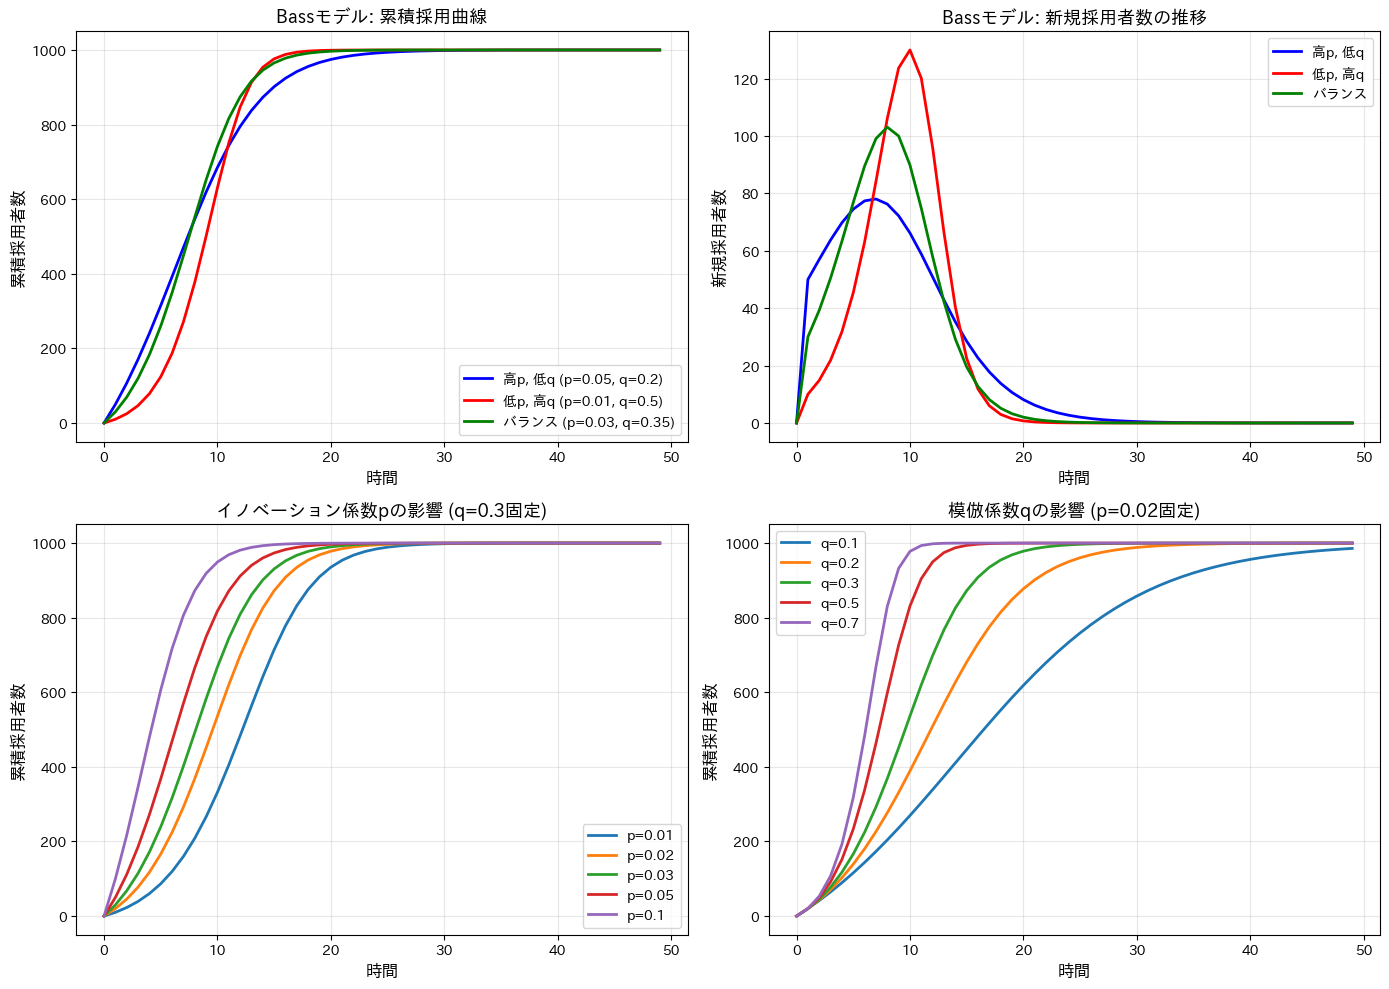

Bassモデルのパラメータ解釈:
  p（イノベーション係数）: 外部情報による採用、マスメディアの影響
  q（模倣係数）: 口コミ、社会的影響による採用

  高p: 初期から急速に普及（広告主導型）
  高q: 後半で加速（口コミ主導型）


In [3]:
def bass_model(M, p, q, T=50):
    """
    Bassモデルによる普及シミュレーション
    
    Parameters:
    -----------
    M : int
        潜在的採用者の総数
    p : float
        イノベーション係数（外部影響）
    q : float
        模倣係数（内部影響）
    T : int
        シミュレーション期間
    """
    N = np.zeros(T)
    n = np.zeros(T)  # 各期の新規採用者数
    
    for t in range(1, T):
        # 新規採用者数
        remaining = M - N[t-1]
        adoption_rate = p + q * (N[t-1] / M)
        n[t] = adoption_rate * remaining
        N[t] = N[t-1] + n[t]
    
    return N, n

# 異なるパラメータでの比較
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

M = 1000
T = 50

# ケース1: 高イノベーション、低模倣（新技術）
N1, n1 = bass_model(M, p=0.05, q=0.2, T=T)
# ケース2: 低イノベーション、高模倣（ファッション）
N2, n2 = bass_model(M, p=0.01, q=0.5, T=T)
# ケース3: バランス型
N3, n3 = bass_model(M, p=0.03, q=0.35, T=T)

# 累積採用者数
axes[0, 0].plot(range(T), N1, 'b-', linewidth=2, label='高p, 低q (p=0.05, q=0.2)')
axes[0, 0].plot(range(T), N2, 'r-', linewidth=2, label='低p, 高q (p=0.01, q=0.5)')
axes[0, 0].plot(range(T), N3, 'g-', linewidth=2, label='バランス (p=0.03, q=0.35)')
axes[0, 0].set_xlabel('時間', fontsize=12)
axes[0, 0].set_ylabel('累積採用者数', fontsize=12)
axes[0, 0].set_title('Bassモデル: 累積採用曲線', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 新規採用者数
axes[0, 1].plot(range(T), n1, 'b-', linewidth=2, label='高p, 低q')
axes[0, 1].plot(range(T), n2, 'r-', linewidth=2, label='低p, 高q')
axes[0, 1].plot(range(T), n3, 'g-', linewidth=2, label='バランス')
axes[0, 1].set_xlabel('時間', fontsize=12)
axes[0, 1].set_ylabel('新規採用者数', fontsize=12)
axes[0, 1].set_title('Bassモデル: 新規採用者数の推移', fontsize=13)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# p/q比と普及パターン
p_values = [0.01, 0.02, 0.03, 0.05, 0.1]
q_fixed = 0.3

for p in p_values:
    N, _ = bass_model(M, p=p, q=q_fixed, T=T)
    axes[1, 0].plot(range(T), N, linewidth=2, label=f'p={p}')

axes[1, 0].set_xlabel('時間', fontsize=12)
axes[1, 0].set_ylabel('累積採用者数', fontsize=12)
axes[1, 0].set_title(f'イノベーション係数pの影響 (q={q_fixed}固定)', fontsize=13)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# qの影響
p_fixed = 0.02
q_values = [0.1, 0.2, 0.3, 0.5, 0.7]

for q in q_values:
    N, _ = bass_model(M, p=p_fixed, q=q, T=T)
    axes[1, 1].plot(range(T), N, linewidth=2, label=f'q={q}')

axes[1, 1].set_xlabel('時間', fontsize=12)
axes[1, 1].set_ylabel('累積採用者数', fontsize=12)
axes[1, 1].set_title(f'模倣係数qの影響 (p={p_fixed}固定)', fontsize=13)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Bassモデルのパラメータ解釈:")
print("  p（イノベーション係数）: 外部情報による採用、マスメディアの影響")
print("  q（模倣係数）: 口コミ、社会的影響による採用")
print("\n  高p: 初期から急速に普及（広告主導型）")
print("  高q: 後半で加速（口コミ主導型）")

## A11.3 ネットワーク上での普及シミュレーション

### しきい値モデル

各ノードは、隣接ノードの採用率がしきい値を超えると採用します。

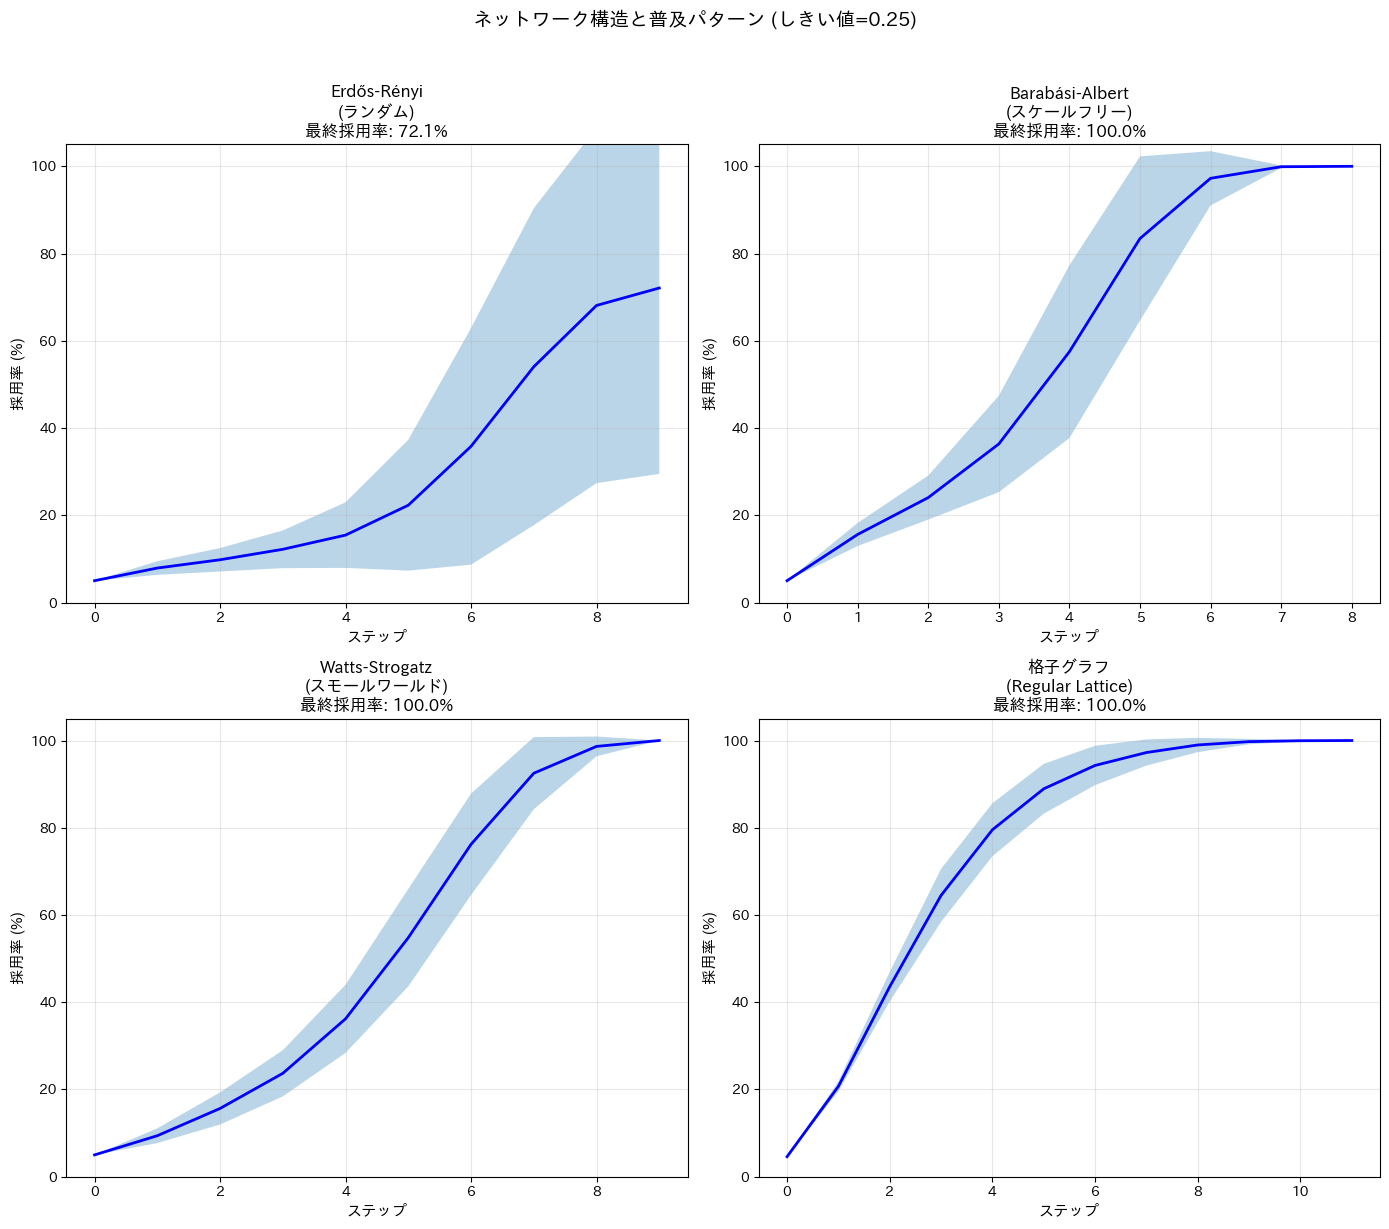

In [4]:
def network_diffusion_threshold(G, initial_adopters, threshold_type='uniform', 
                                  threshold_value=0.3, max_steps=50):
    """
    ネットワーク上でのしきい値モデルによる普及シミュレーション
    
    Parameters:
    -----------
    G : networkx.Graph
        ネットワーク
    initial_adopters : set
        初期採用者のノード集合
    threshold_type : str
        'uniform': 全ノード同じしきい値
        'random': ランダムなしきい値
    threshold_value : float
        しきい値（uniformの場合）または平均値（randomの場合）
    """
    # しきい値を設定
    if threshold_type == 'uniform':
        thresholds = {n: threshold_value for n in G.nodes()}
    else:
        thresholds = {n: np.random.uniform(0, 2 * threshold_value) for n in G.nodes()}
    
    # 採用状態
    adopted = initial_adopters.copy()
    history = [len(adopted)]
    
    for step in range(max_steps):
        new_adopters = set()
        
        for node in G.nodes():
            if node in adopted:
                continue
            
            # 隣接ノードの採用率を計算
            neighbors = list(G.neighbors(node))
            if len(neighbors) == 0:
                continue
            
            adopted_neighbors = sum(1 for n in neighbors if n in adopted)
            adoption_rate = adopted_neighbors / len(neighbors)
            
            if adoption_rate >= thresholds[node]:
                new_adopters.add(node)
        
        if not new_adopters:
            break
        
        adopted.update(new_adopters)
        history.append(len(adopted))
    
    return adopted, history, thresholds

# 異なるネットワーク構造での普及比較
n = 200
networks = {
    'Erdős-Rényi\n(ランダム)': nx.erdos_renyi_graph(n, 0.05, seed=42),
    'Barabási-Albert\n(スケールフリー)': nx.barabasi_albert_graph(n, 3, seed=42),
    'Watts-Strogatz\n(スモールワールド)': nx.watts_strogatz_graph(n, 6, 0.3, seed=42),
    '格子グラフ\n(Regular Lattice)': nx.grid_2d_graph(14, 14)
}

# 格子グラフのノードを整数に変換
networks['格子グラフ\n(Regular Lattice)'] = nx.convert_node_labels_to_integers(
    networks['格子グラフ\n(Regular Lattice)']
)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

initial_fraction = 0.05
threshold = 0.25

for ax, (name, G) in zip(axes, networks.items()):
    # 初期採用者をランダムに選択
    n_initial = int(G.number_of_nodes() * initial_fraction)
    initial_adopters = set(random.sample(list(G.nodes()), n_initial))
    
    # 複数回シミュレーション
    histories = []
    for trial in range(10):
        random.seed(trial)
        initial = set(random.sample(list(G.nodes()), n_initial))
        _, history, _ = network_diffusion_threshold(G, initial, 
                                                     threshold_value=threshold)
        histories.append(history)
    
    # 平均と標準偏差
    max_len = max(len(h) for h in histories)
    padded = [h + [h[-1]] * (max_len - len(h)) for h in histories]
    mean_history = np.mean(padded, axis=0)
    std_history = np.std(padded, axis=0)
    
    steps = range(len(mean_history))
    ax.plot(steps, mean_history / G.number_of_nodes() * 100, 'b-', linewidth=2)
    ax.fill_between(steps, 
                    (mean_history - std_history) / G.number_of_nodes() * 100,
                    (mean_history + std_history) / G.number_of_nodes() * 100,
                    alpha=0.3)
    
    final_adoption = mean_history[-1] / G.number_of_nodes() * 100
    ax.set_xlabel('ステップ', fontsize=11)
    ax.set_ylabel('採用率 (%)', fontsize=11)
    ax.set_title(f'{name}\n最終採用率: {final_adoption:.1f}%', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 105)

plt.suptitle(f'ネットワーク構造と普及パターン (しきい値={threshold})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

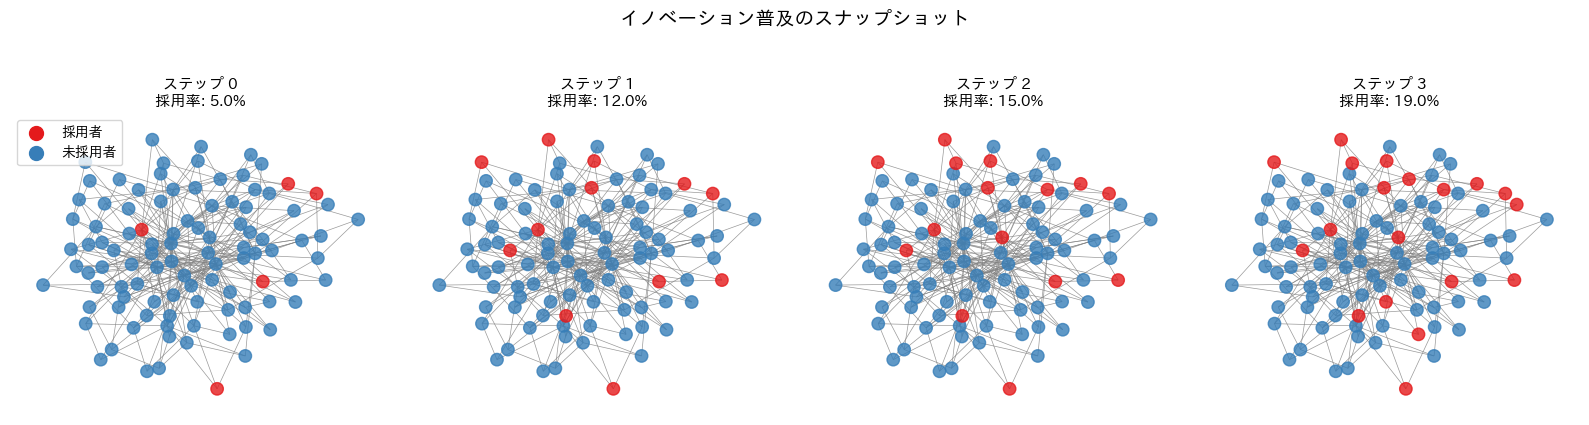

In [5]:
# 普及の可視化（スナップショット）
G = nx.barabasi_albert_graph(100, 3, seed=42)
initial_adopters = set(random.sample(list(G.nodes()), 5))

# シミュレーション実行
adopted = initial_adopters.copy()
snapshots = [adopted.copy()]
thresholds = {n: 0.3 for n in G.nodes()}

for step in range(20):
    new_adopters = set()
    for node in G.nodes():
        if node in adopted:
            continue
        neighbors = list(G.neighbors(node))
        if len(neighbors) == 0:
            continue
        adopted_neighbors = sum(1 for n in neighbors if n in adopted)
        if adopted_neighbors / len(neighbors) >= thresholds[node]:
            new_adopters.add(node)
    if not new_adopters:
        break
    adopted.update(new_adopters)
    snapshots.append(adopted.copy())

# 4つのスナップショットを表示
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
pos = nx.spring_layout(G, seed=42)

snapshot_indices = [0, len(snapshots)//3, 2*len(snapshots)//3, len(snapshots)-1]
snapshot_indices = [min(i, len(snapshots)-1) for i in snapshot_indices]

for ax, idx in zip(axes, snapshot_indices):
    adopted_at_step = snapshots[idx]
    colors = ['#e41a1c' if n in adopted_at_step else '#377eb8' for n in G.nodes()]
    
    nx.draw(G, pos, ax=ax, node_color=colors, node_size=80,
            edge_color='gray', alpha=0.8, width=0.5)
    
    adoption_rate = len(adopted_at_step) / G.number_of_nodes() * 100
    ax.set_title(f'ステップ {idx}\n採用率: {adoption_rate:.1f}%', fontsize=11)

# 凡例
axes[0].scatter([], [], c='#e41a1c', s=100, label='採用者')
axes[0].scatter([], [], c='#377eb8', s=100, label='未採用者')
axes[0].legend(loc='upper left')

plt.suptitle('イノベーション普及のスナップショット', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

## A11.4 初期採用者の影響

### シードの選択戦略

どのノードを初期採用者（シード）として選ぶかは普及成功に大きく影響します。

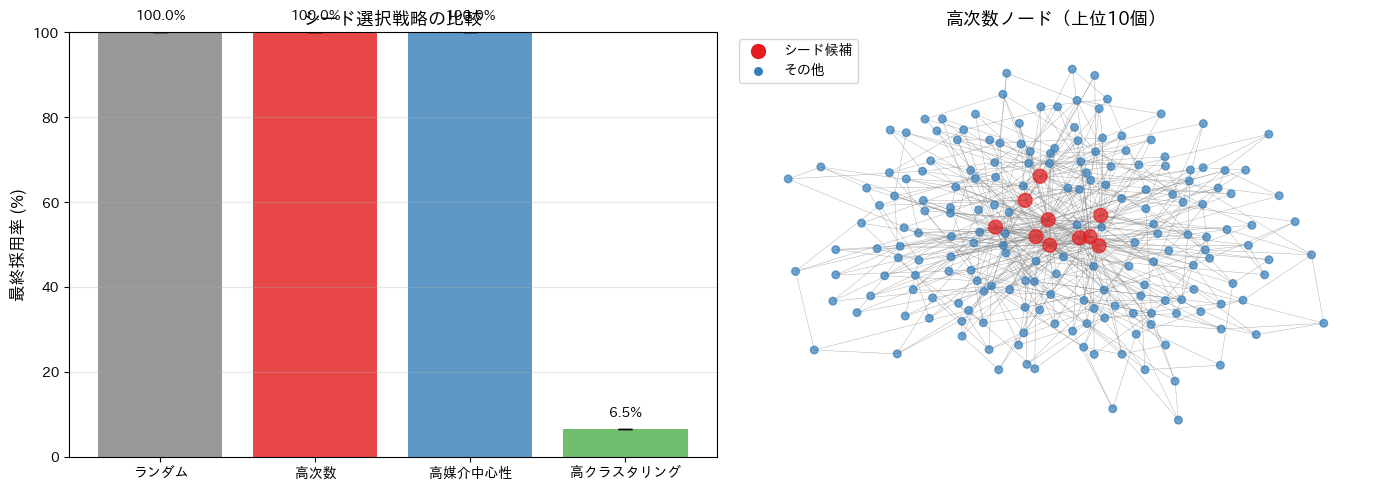

シード選択戦略の結果:
  ランダム: 100.0% ± 0.0%
  高次数: 100.0% ± 0.0%
  高媒介中心性: 100.0% ± 0.0%
  高クラスタリング: 6.5% ± 0.0%


In [6]:
def compare_seeding_strategies(G, n_seeds, threshold=0.25, n_trials=20):
    """
    異なるシード選択戦略を比較
    """
    strategies = {
        'ランダム': lambda G, k: set(random.sample(list(G.nodes()), k)),
        '高次数': lambda G, k: set(sorted(G.nodes(), 
                                         key=lambda x: G.degree(x), reverse=True)[:k]),
        '高媒介中心性': lambda G, k: set(sorted(G.nodes(),
                                              key=lambda x: nx.betweenness_centrality(G)[x],
                                              reverse=True)[:k]),
        '高クラスタリング': lambda G, k: set(sorted(G.nodes(),
                                                 key=lambda x: nx.clustering(G, x),
                                                 reverse=True)[:k]),
    }
    
    results = {}
    
    for name, strategy in strategies.items():
        final_adoptions = []
        
        for trial in range(n_trials):
            if name == 'ランダム':
                random.seed(trial)
            initial = strategy(G, n_seeds)
            adopted, _, _ = network_diffusion_threshold(G, initial, 
                                                         threshold_value=threshold)
            final_adoptions.append(len(adopted) / G.number_of_nodes())
        
        results[name] = (np.mean(final_adoptions), np.std(final_adoptions))
    
    return results

# スケールフリーネットワークでの比較
G = nx.barabasi_albert_graph(200, 3, seed=42)
n_seeds = 10

results = compare_seeding_strategies(G, n_seeds, threshold=0.25)

# 結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 棒グラフ
names = list(results.keys())
means = [results[n][0] * 100 for n in names]
stds = [results[n][1] * 100 for n in names]
colors = ['#808080', '#e41a1c', '#377eb8', '#4daf4a']

bars = axes[0].bar(names, means, yerr=stds, capsize=5, color=colors, alpha=0.8)
axes[0].set_ylabel('最終採用率 (%)', fontsize=12)
axes[0].set_title('シード選択戦略の比較', fontsize=13)
axes[0].set_ylim(0, 100)
axes[0].grid(True, alpha=0.3, axis='y')

# 値をバーの上に表示
for bar, mean in zip(bars, means):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
                f'{mean:.1f}%', ha='center', fontsize=10)

# ネットワーク図（高次数ノードをハイライト）
pos = nx.spring_layout(G, seed=42)
degrees = dict(G.degree())
top_nodes = set(sorted(G.nodes(), key=lambda x: degrees[x], reverse=True)[:n_seeds])

node_colors = ['#e41a1c' if n in top_nodes else '#377eb8' for n in G.nodes()]
node_sizes = [100 if n in top_nodes else 30 for n in G.nodes()]

nx.draw(G, pos, ax=axes[1], node_color=node_colors, node_size=node_sizes,
        edge_color='gray', alpha=0.7, width=0.3)
axes[1].set_title(f'高次数ノード（上位{n_seeds}個）', fontsize=13)

axes[1].scatter([], [], c='#e41a1c', s=100, label='シード候補')
axes[1].scatter([], [], c='#377eb8', s=30, label='その他')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

print("シード選択戦略の結果:")
for name, (mean, std) in results.items():
    print(f"  {name}: {mean*100:.1f}% ± {std*100:.1f}%")

## A11.5 クリティカルマス

### 臨界質量（Critical Mass）

普及が自律的に進むために必要な最小限の採用者数をクリティカルマスと呼びます。

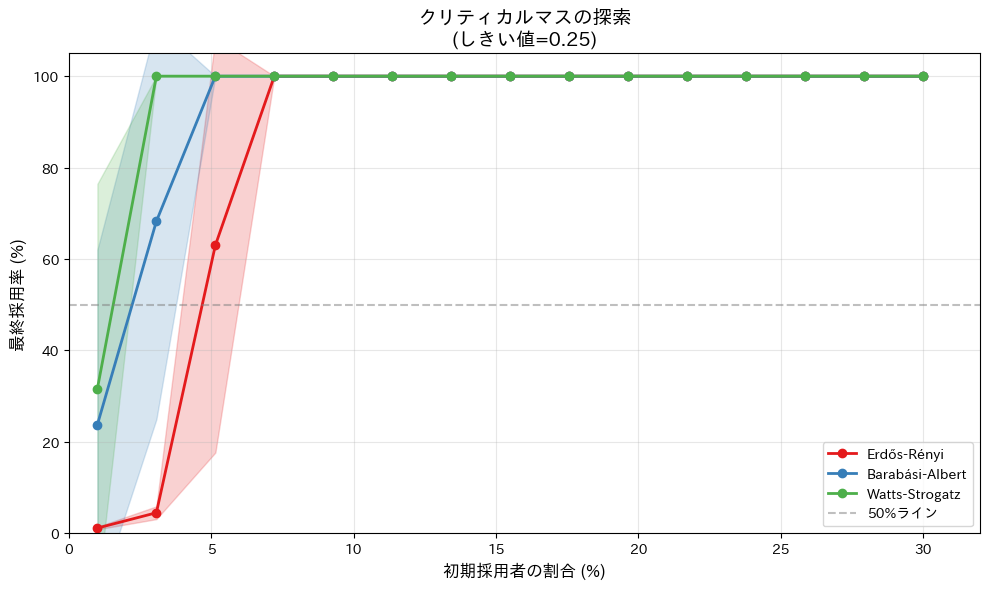

クリティカルマスの解釈:
  曲線が急上昇するポイントがクリティカルマス
  このポイントを超えると普及が加速


In [7]:
def find_critical_mass(G, threshold=0.25, n_trials=20):
    """
    クリティカルマスを探索
    初期採用者の割合を変えて、最終採用率を測定
    """
    initial_fractions = np.linspace(0.01, 0.3, 15)
    results = []
    
    for frac in initial_fractions:
        n_initial = max(1, int(G.number_of_nodes() * frac))
        final_adoptions = []
        
        for trial in range(n_trials):
            random.seed(trial)
            initial = set(random.sample(list(G.nodes()), n_initial))
            adopted, _, _ = network_diffusion_threshold(G, initial,
                                                         threshold_value=threshold)
            final_adoptions.append(len(adopted) / G.number_of_nodes())
        
        results.append((frac, np.mean(final_adoptions), np.std(final_adoptions)))
    
    return results

# 異なるネットワークでクリティカルマスを比較
networks_cm = {
    'Erdős-Rényi': nx.erdos_renyi_graph(200, 0.05, seed=42),
    'Barabási-Albert': nx.barabasi_albert_graph(200, 3, seed=42),
    'Watts-Strogatz': nx.watts_strogatz_graph(200, 6, 0.3, seed=42),
}

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e41a1c', '#377eb8', '#4daf4a']

for (name, G), color in zip(networks_cm.items(), colors):
    results = find_critical_mass(G, threshold=0.25)
    fracs = [r[0] * 100 for r in results]
    means = [r[1] * 100 for r in results]
    stds = [r[2] * 100 for r in results]
    
    ax.plot(fracs, means, 'o-', color=color, linewidth=2, markersize=6, label=name)
    ax.fill_between(fracs, 
                    [m - s for m, s in zip(means, stds)],
                    [m + s for m, s in zip(means, stds)],
                    alpha=0.2, color=color)

ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50%ライン')
ax.set_xlabel('初期採用者の割合 (%)', fontsize=12)
ax.set_ylabel('最終採用率 (%)', fontsize=12)
ax.set_title('クリティカルマスの探索\n(しきい値=0.25)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 32)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

print("クリティカルマスの解釈:")
print("  曲線が急上昇するポイントがクリティカルマス")
print("  このポイントを超えると普及が加速")

## A11.6 しきい値の異質性

### 個人差の影響

実際には、人々の採用しきい値は異なります。この異質性が普及に与える影響を分析します。

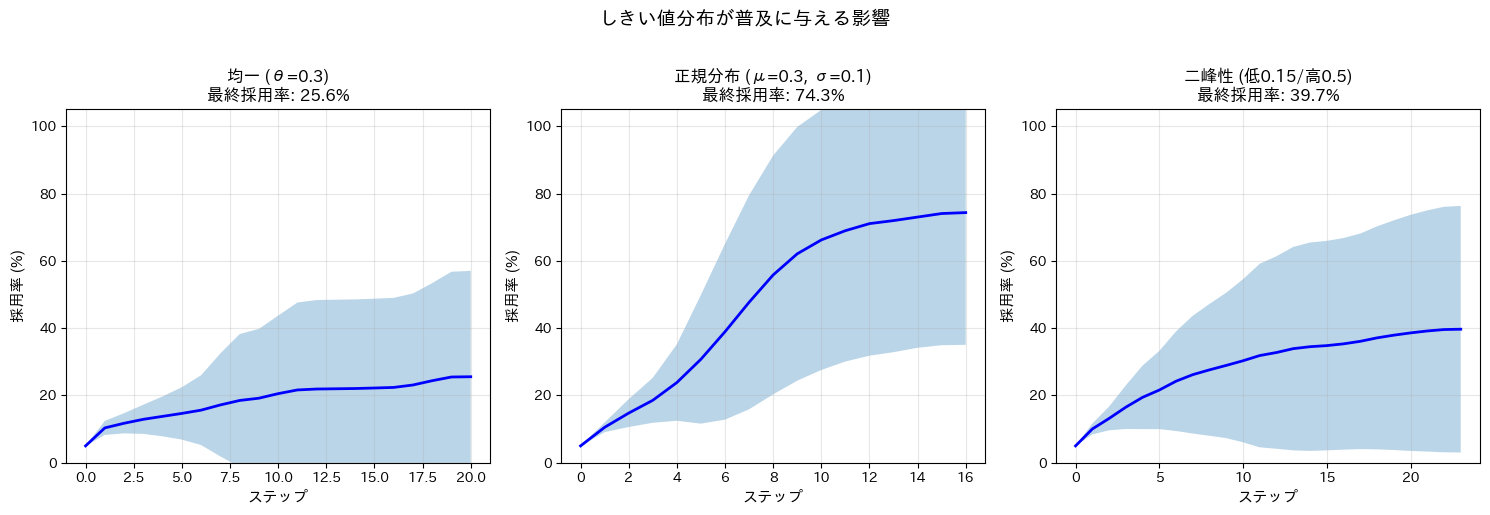

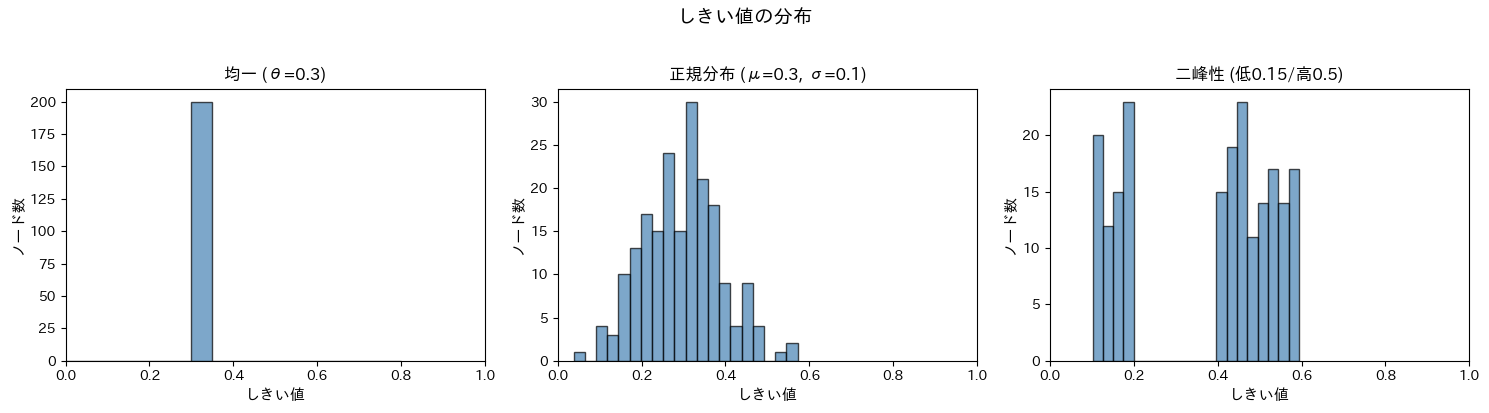

In [8]:
def network_diffusion_heterogeneous(G, initial_adopters, threshold_dist='uniform',
                                     mean_threshold=0.3, std_threshold=0.1, max_steps=50):
    """
    異質なしきい値を持つノードでの普及シミュレーション
    """
    # しきい値を分布から生成
    if threshold_dist == 'uniform':
        thresholds = {n: mean_threshold for n in G.nodes()}
    elif threshold_dist == 'normal':
        thresholds = {n: max(0, min(1, np.random.normal(mean_threshold, std_threshold)))
                     for n in G.nodes()}
    elif threshold_dist == 'bimodal':
        # 低しきい値と高しきい値のグループ
        thresholds = {}
        for n in G.nodes():
            if random.random() < 0.3:  # 30%が低しきい値
                thresholds[n] = np.random.uniform(0.1, 0.2)
            else:
                thresholds[n] = np.random.uniform(0.4, 0.6)
    
    # 採用状態
    adopted = initial_adopters.copy()
    history = [len(adopted)]
    
    for step in range(max_steps):
        new_adopters = set()
        
        for node in G.nodes():
            if node in adopted:
                continue
            
            neighbors = list(G.neighbors(node))
            if len(neighbors) == 0:
                continue
            
            adopted_neighbors = sum(1 for n in neighbors if n in adopted)
            adoption_rate = adopted_neighbors / len(neighbors)
            
            if adoption_rate >= thresholds[node]:
                new_adopters.add(node)
        
        if not new_adopters:
            break
        
        adopted.update(new_adopters)
        history.append(len(adopted))
    
    return adopted, history, thresholds

# しきい値分布の比較
G = nx.barabasi_albert_graph(200, 3, seed=42)
n_initial = 10

distributions = ['uniform', 'normal', 'bimodal']
dist_names = ['均一 (θ=0.3)', '正規分布 (μ=0.3, σ=0.1)', '二峰性 (低0.15/高0.5)']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, dist, name in zip(axes, distributions, dist_names):
    histories = []
    all_thresholds = []
    
    for trial in range(20):
        random.seed(trial)
        np.random.seed(trial)
        initial = set(random.sample(list(G.nodes()), n_initial))
        _, history, thresholds = network_diffusion_heterogeneous(
            G, initial, threshold_dist=dist
        )
        histories.append(history)
        all_thresholds.append(list(thresholds.values()))
    
    # 平均と標準偏差
    max_len = max(len(h) for h in histories)
    padded = [h + [h[-1]] * (max_len - len(h)) for h in histories]
    mean_history = np.mean(padded, axis=0)
    std_history = np.std(padded, axis=0)
    
    steps = range(len(mean_history))
    ax.plot(steps, mean_history / G.number_of_nodes() * 100, 'b-', linewidth=2)
    ax.fill_between(steps,
                    (mean_history - std_history) / G.number_of_nodes() * 100,
                    (mean_history + std_history) / G.number_of_nodes() * 100,
                    alpha=0.3)
    
    final = mean_history[-1] / G.number_of_nodes() * 100
    ax.set_xlabel('ステップ', fontsize=11)
    ax.set_ylabel('採用率 (%)', fontsize=11)
    ax.set_title(f'{name}\n最終採用率: {final:.1f}%', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 105)

plt.suptitle('しきい値分布が普及に与える影響', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# しきい値分布の可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, dist, name in zip(axes, distributions, dist_names):
    np.random.seed(42)
    random.seed(42)
    _, _, thresholds = network_diffusion_heterogeneous(
        G, set(), threshold_dist=dist
    )
    ax.hist(list(thresholds.values()), bins=20, color='steelblue', 
            alpha=0.7, edgecolor='black')
    ax.set_xlabel('しきい値', fontsize=11)
    ax.set_ylabel('ノード数', fontsize=11)
    ax.set_title(f'{name}', fontsize=12)
    ax.set_xlim(0, 1)

plt.suptitle('しきい値の分布', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## A11.7 普及とネットワーク指標の関係

ネットワークの構造的特性と普及成功の関係を分析します。

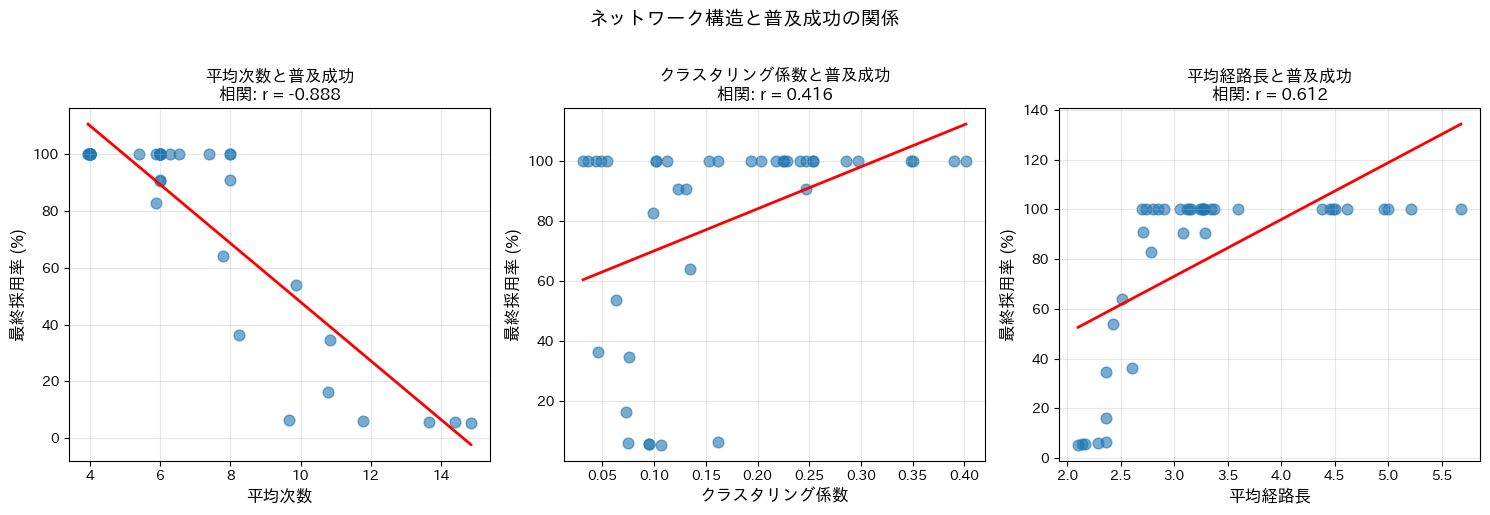

分析結果の解釈:
  平均次数: 高いほど普及しやすい（接触機会が多い）
  クラスタリング: 高いとローカルで広がるが全体には広がりにくい場合も
  平均経路長: 短いほど普及しやすい（情報が早く届く）


In [9]:
def analyze_network_diffusion_correlation(n_networks=30):
    """
    ネットワーク指標と普及成功の相関を分析
    """
    data = []
    
    for i in range(n_networks):
        # ランダムにネットワークを生成
        network_type = random.choice(['er', 'ba', 'ws'])
        
        if network_type == 'er':
            p = random.uniform(0.03, 0.1)
            G = nx.erdos_renyi_graph(150, p, seed=i)
        elif network_type == 'ba':
            m = random.randint(2, 5)
            G = nx.barabasi_albert_graph(150, m, seed=i)
        else:
            k = random.randint(4, 8)
            p = random.uniform(0.1, 0.5)
            G = nx.watts_strogatz_graph(150, k, p, seed=i)
        
        # 連結でない場合はスキップ
        if not nx.is_connected(G):
            continue
        
        # ネットワーク指標
        avg_degree = np.mean([d for n, d in G.degree()])
        clustering = nx.average_clustering(G)
        avg_path = nx.average_shortest_path_length(G)
        
        # 普及シミュレーション
        n_initial = int(G.number_of_nodes() * 0.05)
        final_adoptions = []
        
        for trial in range(10):
            random.seed(trial + i * 100)
            initial = set(random.sample(list(G.nodes()), n_initial))
            adopted, _, _ = network_diffusion_threshold(G, initial, threshold_value=0.25)
            final_adoptions.append(len(adopted) / G.number_of_nodes())
        
        data.append({
            'avg_degree': avg_degree,
            'clustering': clustering,
            'avg_path': avg_path,
            'final_adoption': np.mean(final_adoptions)
        })
    
    return data

# 分析実行
data = analyze_network_diffusion_correlation(n_networks=40)

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['avg_degree', 'clustering', 'avg_path']
metric_names = ['平均次数', 'クラスタリング係数', '平均経路長']

for ax, metric, name in zip(axes, metrics, metric_names):
    x = [d[metric] for d in data]
    y = [d['final_adoption'] * 100 for d in data]
    
    ax.scatter(x, y, alpha=0.6, s=60)
    
    # 回帰直線
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(min(x), max(x), 100)
    ax.plot(x_line, p(x_line), 'r-', linewidth=2)
    
    # 相関係数
    corr = np.corrcoef(x, y)[0, 1]
    
    ax.set_xlabel(name, fontsize=12)
    ax.set_ylabel('最終採用率 (%)', fontsize=12)
    ax.set_title(f'{name}と普及成功\n相関: r = {corr:.3f}', fontsize=12)
    ax.grid(True, alpha=0.3)

plt.suptitle('ネットワーク構造と普及成功の関係', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("分析結果の解釈:")
print("  平均次数: 高いほど普及しやすい（接触機会が多い）")
print("  クラスタリング: 高いとローカルで広がるが全体には広がりにくい場合も")
print("  平均経路長: 短いほど普及しやすい（情報が早く届く）")

## A11.8 まとめ

### イノベーション普及の主要概念

| 概念 | 説明 |
|------|------|
| S字曲線 | 累積採用率が描く典型的なパターン |
| 採用者カテゴリ | イノベーター→アーリーアダプター→マジョリティ→ラガード |
| クリティカルマス | 普及が自律的に進む最小限の採用者数 |
| しきい値モデル | 隣接ノードの採用率に基づく採用決定 |
| Bassモデル | イノベーション効果(p)と模倣効果(q)の組み合わせ |

### ネットワーク構造と普及

1. **スケールフリーネットワーク**
   - ハブを通じた効率的な普及
   - ハブをシードにすると効果的

2. **スモールワールドネットワーク**
   - 短い経路長で迅速な普及
   - ローカルなクラスタリングと広域な接続の両立

3. **シード選択戦略**
   - 高次数ノード: 多くの人に直接リーチ
   - 高媒介中心性ノード: 異なるグループをつなぐ

---

## 練習問題

### 問題1: Bassモデルのパラメータ推定

以下の累積採用データに対して、Bassモデルのパラメータ(p, q)を推定してください。

ヒント: 様々なp, qの組み合わせを試し、データとの誤差が最小になるものを探してください。

In [10]:
# 観測データ（累積採用者数）
observed_data = [5, 15, 35, 80, 150, 280, 450, 620, 750, 850, 910, 950, 975, 990, 998]
M = 1000  # 潜在的採用者の総数

# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
def fit_bass_model(observed, M, p_range, q_range):
    """グリッドサーチでBassモデルのパラメータを推定"""
    best_error = float('inf')
    best_params = None
    
    for p in p_range:
        for q in q_range:
            predicted, _ = bass_model(M, p, q, T=len(observed))
            error = np.sum((np.array(observed) - predicted[:len(observed)])**2)
            
            if error < best_error:
                best_error = error
                best_params = (p, q)
    
    return best_params, best_error

# パラメータ探索
p_range = np.linspace(0.001, 0.1, 50)
q_range = np.linspace(0.1, 0.8, 50)

best_params, best_error = fit_bass_model(observed_data, M, p_range, q_range)
print(f"推定パラメータ: p = {best_params[0]:.4f}, q = {best_params[1]:.4f}")

# 結果の可視化
predicted, _ = bass_model(M, best_params[0], best_params[1], T=len(observed_data))

plt.figure(figsize=(10, 6))
plt.plot(range(len(observed_data)), observed_data, 'bo-', label='観測データ')
plt.plot(range(len(observed_data)), predicted[:len(observed_data)], 'r--', 
         linewidth=2, label=f'Bassモデル (p={best_params[0]:.3f}, q={best_params[1]:.3f})')
plt.xlabel('時間')
plt.ylabel('累積採用者数')
plt.title('Bassモデルのフィッティング')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
```
</details>

### 問題2: 最適なシード数

固定予算（シード数）の制約のもとで、普及を最大化するには何人のシードが必要かを分析してください。

条件:
- ネットワーク: Barabási-Albertモデル (n=300, m=3)
- シード選択: 高次数ノード
- しきい値: 0.25

In [11]:
# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
G = nx.barabasi_albert_graph(300, 3, seed=42)

# 高次数ノードをシードとして使用
degrees = dict(G.degree())
sorted_nodes = sorted(G.nodes(), key=lambda x: degrees[x], reverse=True)

seed_counts = range(1, 51, 2)
results = []

for n_seeds in seed_counts:
    initial = set(sorted_nodes[:n_seeds])
    final_adoptions = []
    
    for trial in range(20):
        adopted, _, _ = network_diffusion_threshold(G, initial, threshold_value=0.25)
        final_adoptions.append(len(adopted) / G.number_of_nodes())
    
    results.append((n_seeds, np.mean(final_adoptions), np.std(final_adoptions)))

# 可視化
fig, ax = plt.subplots(figsize=(10, 6))

seeds = [r[0] for r in results]
means = [r[1] * 100 for r in results]
stds = [r[2] * 100 for r in results]

ax.errorbar(seeds, means, yerr=stds, fmt='o-', capsize=3)
ax.set_xlabel('シード数', fontsize=12)
ax.set_ylabel('最終採用率 (%)', fontsize=12)
ax.set_title('シード数と普及成功の関係', fontsize=14)
ax.grid(True, alpha=0.3)

# 効率性（採用率/シード数）を計算
efficiency = [m / s for s, m, _ in results]
best_idx = np.argmax(efficiency)
print(f"最も効率的なシード数: {results[best_idx][0]}")
print(f"その時の採用率: {results[best_idx][1]*100:.1f}%")

plt.show()
```
</details>

### 問題3: 複数イノベーションの競合

2つの競合するイノベーション（例：製品AとB）が同時に普及する状況をシミュレーションしてください。

ルール:
- 各ノードはAかBのどちらか一方のみ採用可能
- 採用していない隣接ノードの過半数が採用した方を採用
- 初期にランダムで5%ずつがA、Bを採用

In [12]:
# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
def competing_diffusion(G, initial_A, initial_B, max_steps=50):
    """2つのイノベーションの競合シミュレーション"""
    adopted_A = initial_A.copy()
    adopted_B = initial_B.copy()
    
    history_A = [len(adopted_A)]
    history_B = [len(adopted_B)]
    
    for step in range(max_steps):
        new_A = set()
        new_B = set()
        
        for node in G.nodes():
            if node in adopted_A or node in adopted_B:
                continue
            
            neighbors = list(G.neighbors(node))
            if len(neighbors) == 0:
                continue
            
            n_A = sum(1 for n in neighbors if n in adopted_A)
            n_B = sum(1 for n in neighbors if n in adopted_B)
            
            # 過半数が採用した方を選択
            threshold = len(neighbors) * 0.3
            if n_A > n_B and n_A >= threshold:
                new_A.add(node)
            elif n_B > n_A and n_B >= threshold:
                new_B.add(node)
        
        if not new_A and not new_B:
            break
        
        adopted_A.update(new_A)
        adopted_B.update(new_B)
        history_A.append(len(adopted_A))
        history_B.append(len(adopted_B))
    
    return adopted_A, adopted_B, history_A, history_B

# シミュレーション
G = nx.barabasi_albert_graph(200, 3, seed=42)
nodes = list(G.nodes())
random.shuffle(nodes)

n_initial = int(len(nodes) * 0.05)
initial_A = set(nodes[:n_initial])
initial_B = set(nodes[n_initial:2*n_initial])

adopted_A, adopted_B, history_A, history_B = competing_diffusion(G, initial_A, initial_B)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 時系列
axes[0].plot(range(len(history_A)), [h/len(nodes)*100 for h in history_A], 
             'b-', linewidth=2, label='製品A')
axes[0].plot(range(len(history_B)), [h/len(nodes)*100 for h in history_B], 
             'r-', linewidth=2, label='製品B')
axes[0].set_xlabel('ステップ')
axes[0].set_ylabel('採用率 (%)')
axes[0].set_title('競合イノベーションの普及')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ネットワーク図
pos = nx.spring_layout(G, seed=42)
colors = []
for n in G.nodes():
    if n in adopted_A:
        colors.append('#377eb8')
    elif n in adopted_B:
        colors.append('#e41a1c')
    else:
        colors.append('#808080')

nx.draw(G, pos, ax=axes[1], node_color=colors, node_size=50,
        edge_color='gray', alpha=0.7, width=0.3)
axes[1].set_title('最終状態')

print(f"製品A採用率: {len(adopted_A)/len(nodes)*100:.1f}%")
print(f"製品B採用率: {len(adopted_B)/len(nodes)*100:.1f}%")
print(f"未採用: {(len(nodes)-len(adopted_A)-len(adopted_B))/len(nodes)*100:.1f}%")

plt.tight_layout()
plt.show()
```
</details>

---

## 参考文献

1. Rogers, E. M. (1962). Diffusion of Innovations. Free Press.

2. Bass, F. M. (1969). A new product growth for model consumer durables. Management Science, 15(5), 215-227.

3. Granovetter, M. (1978). Threshold models of collective behavior. American Journal of Sociology, 83(6), 1420-1443.

4. Valente, T. W. (1995). Network Models of the Diffusion of Innovations. Hampton Press.